In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Data Understanding

 ***Done by Poh Xiao Hui***

In [6]:
spreadsheet = pd.read_csv('dataset.csv')

In [7]:
spreadsheet.head()

,ID,travel_fee,departure_time,departure_long,departure_lat,arrival_long,arrival_lat,occupancy
0,54:00.0,7.0,2013-07-02 19:54:00+00:00,-74.005360,40.728867,-74.008913,40.710907,1.0
1,21:31.0,5.5,2013-09-28 00:21:31+00:00,-74.014165,40.708941,-74.016310,40.716734,1.0
2,18:00.0,21.5,2013-06-16 03:18:00+00:00,-73.991075,40.760352,-73.941382,40.713292,1.0
3,43:00.0,9.5,2013-07-20 13:43:00+00:00,-74.002662,40.723630,-73.991722,40.748905,5.0
4,57:17.0,15.5,2013-11-05 22:57:17+00:00,-73.962397,40.712705,-73.996834,40.680403,2.0


In [8]:
print(spreadsheet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51563 entries, 0 to 51562
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              51563 non-null  object 
 1   travel_fee      51563 non-null  float64
 2   departure_time  51563 non-null  object 
 3   departure_long  51563 non-null  float64
 4   departure_lat   51563 non-null  float64
 5   arrival_long    51562 non-null  float64
 6   arrival_lat     51562 non-null  float64
 7   occupancy       51562 non-null  float64
dtypes: float64(6), object(2)
memory usage: 3.1+ MB
None


In [9]:
print(spreadsheet.describe())

         travel_fee  departure_long  departure_lat  arrival_long  \
count  51563.000000    51563.000000   51563.000000  51562.000000   
mean      12.584247      -72.444027      39.753532    -72.387694   
std       10.797905       11.188902       8.092332     11.363753   
min        0.000000      -84.363473     -74.015385    -84.363473   
25%        6.500000      -73.992048      40.734502    -73.991378   
50%        9.500000      -73.981730      40.752620    -73.980093   
75%       14.000000      -73.966786      40.767021    -73.963364   
max      370.000000       40.810655      49.816667     40.895392   

        arrival_lat     occupancy  
count  51562.000000  51562.000000  
mean      39.724116      1.705267  
std        8.165655      1.371465  
min      -74.014622      1.000000  
25%       40.733497      1.000000  
50%       40.752975      1.000000  
75%       40.767907      2.000000  
max       74.013003      6.000000  


In [10]:
from sklearn.model_selection import train_test_split


train_set, test_set = train_test_split(spreadsheet, test_size=0.2, random_state=42)

print("Length of train_set:", len(train_set))
print("Length of test_set:", len(test_set))

Length of train_set: 41250
Length of test_set: 10313


In [265]:
#calculate distance
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Calculate distances for each row in the DataFrame
train_set['distance_km'] = haversine_distance(train_set['departure_lat'], train_set['departure_long'], train_set['arrival_lat'], train_set['arrival_long'])
test_set['distance_km'] = haversine_distance(train_set['departure_lat'], train_set['departure_long'], train_set['arrival_lat'], train_set['arrival_long'])
# Display the updated DataFrame
print(train_set)
print(test_set)

            ID  travel_fee            departure_time  departure_long  \
48271  01:00.0        8.50 2013-03-18 20:01:00+00:00      -73.969108   
21490  07:00.0       17.50 2013-05-03 18:07:00+00:00      -73.999002   
12481  43:33.0       11.50 2013-04-03 10:43:33+00:00      -73.978440   
5020   52:53.0       34.83 2013-08-03 19:52:53+00:00      -73.870835   
14300  56:24.0        7.00 2013-11-02 19:56:24+00:00      -73.978957   
...        ...         ...                       ...             ...   
11284  38:00.0        8.00 2013-11-02 16:38:00+00:00      -73.976925   
44732  05:00.0        6.50 2013-07-02 20:05:00+00:00      -73.984522   
38158  37:08.0        4.50 2013-09-25 16:37:08+00:00      -73.954534   
860    50:19.0        7.50 2013-08-22 22:50:19+00:00      -73.978476   
15795  11:14.0        8.50 2013-05-14 19:11:14+00:00      -73.982357   

       departure_lat  arrival_long  arrival_lat  occupancy  distance_km  hour  \
48271      40.760992    -73.951433    40.774237       

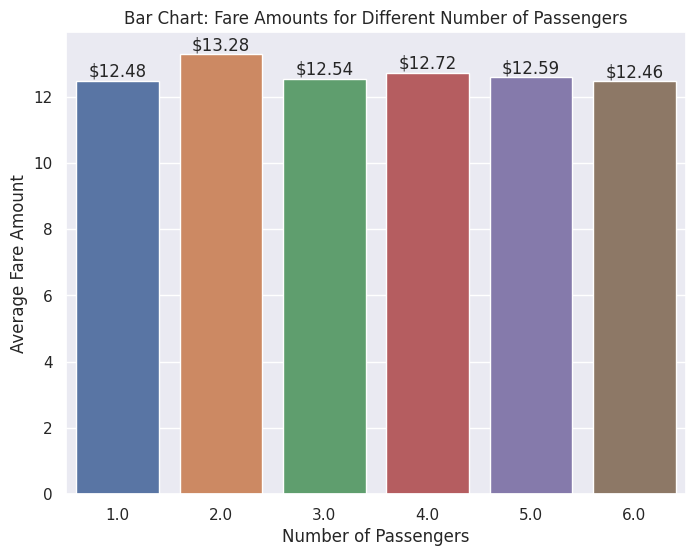

The average fare amount for occupancy 1 is: $12.48


In [12]:
#create bar chart to visualize fare amounts for different number of passengers
avg_fare_by_occupancy = train_set.groupby('occupancy')['travel_fee'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='occupancy', y='travel_fee', data=avg_fare_by_occupancy)
for index, row in avg_fare_by_occupancy.iterrows():
    plt.text(row.name, row['travel_fee'], f"${row['travel_fee']:.2f}", ha='center', va='bottom')
plt.xlabel('Number of Passengers')
plt.ylabel('Average Fare Amount')
plt.title('Bar Chart: Fare Amounts for Different Number of Passengers')
plt.show()

fare_occupancy_1 = avg_fare_by_occupancy.loc[avg_fare_by_occupancy['occupancy'] == 1, 'travel_fee'].values[0]
print(f"The average fare amount for occupancy 1 is: ${fare_occupancy_1:.2f}")

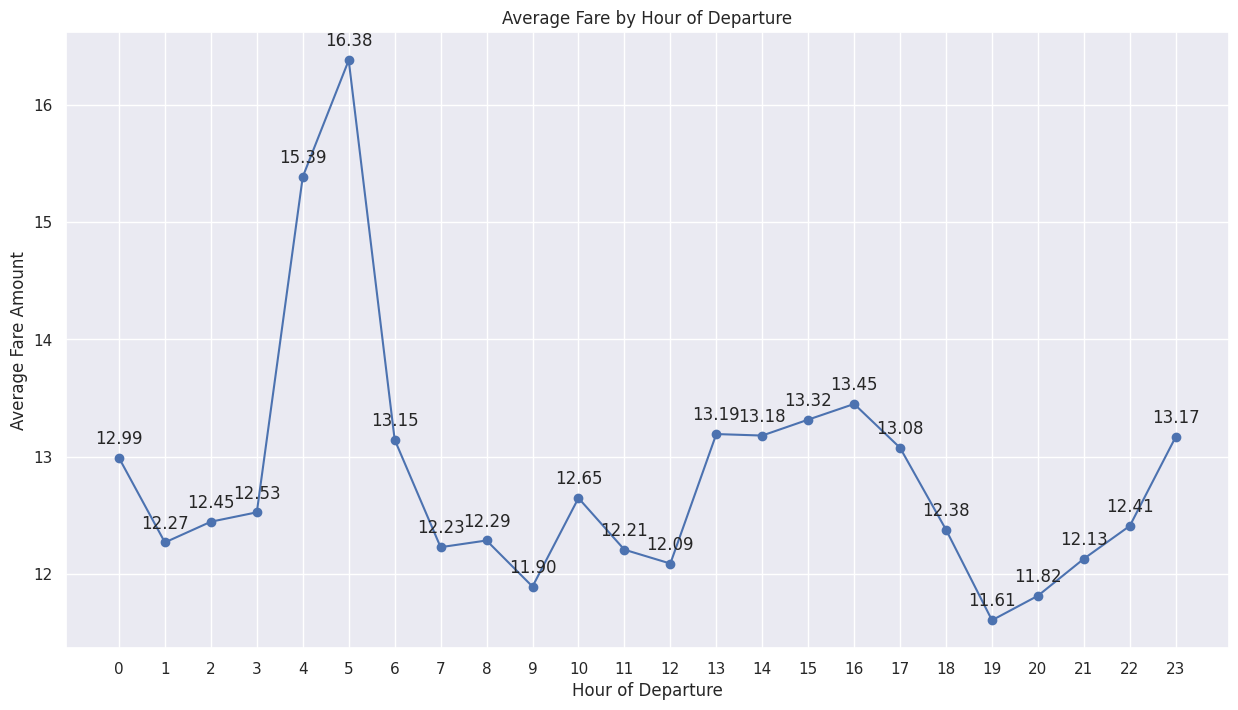

In [266]:
train_set['departure_time'] = pd.to_datetime(train_set['departure_time'])
train_set['hour'] = train_set['departure_time'].dt.hour
test_set['hour'] = train_set['departure_time'].dt.hour
avg_fare_by_hour = train_set.groupby('hour')['travel_fee'].mean().reset_index()

#create line chart for average fare by hour of departure
plt.figure(figsize=(15, 8))
plt.plot(avg_fare_by_hour['hour'], avg_fare_by_hour['travel_fee'], marker='o')
plt.xlabel('Hour of Departure')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare by Hour of Departure')
plt.xticks(range(24))
plt.grid(True)
# Annotate each data point with its value
for hour, fare in zip(avg_fare_by_hour['hour'], avg_fare_by_hour['travel_fee']):
    plt.annotate(f'{fare:.2f}', (hour, fare), textcoords="offset points", xytext=(0, 10), ha='center')
plt.show()

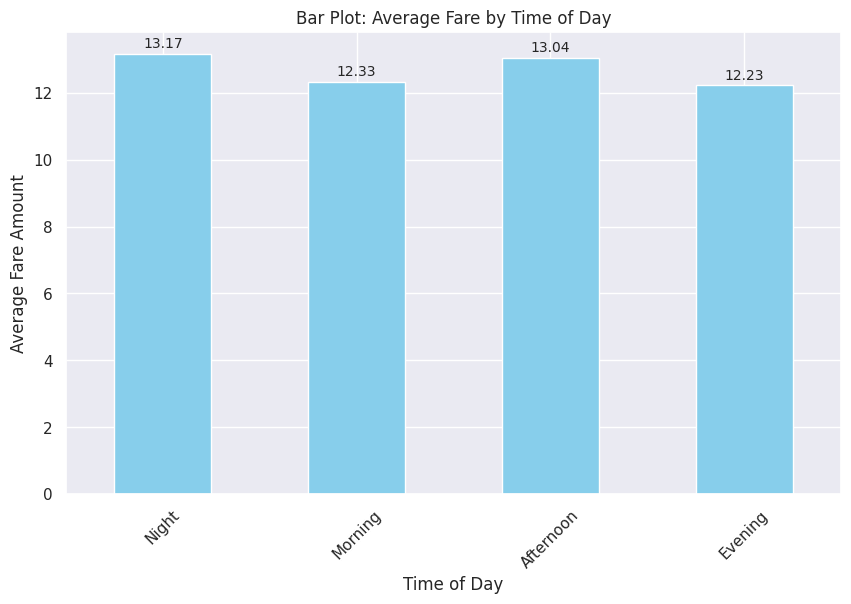

In [270]:
train_set['departure_time'] = pd.to_datetime(train_set['departure_time'])
test_set['departure_time'] = pd.to_datetime(train_set['departure_time'])
# Define time of day bins
time_bins = [0, 6, 12, 18, 24]  # 0-6 (night), 6-12 (morning), 12-18 (afternoon), 18-24 (evening)
time_labels = ['Night', 'Morning', 'Afternoon', 'Evening']

# Categorize departure times into time of day bins
train_set['time_of_day'] = pd.cut(train_set['departure_time'].dt.hour, bins=time_bins, labels=time_labels, right=False)
test_set['time_of_day'] = pd.cut(train_set['departure_time'].dt.hour, bins=time_bins, labels=time_labels, right=False)

# Calculate average fare for each time of day
avg_fare_by_time_of_day = train_set.groupby('time_of_day')['travel_fee'].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
ax=avg_fare_by_time_of_day.plot(kind='bar', color='skyblue')
plt.xlabel('Time of Day')
plt.ylabel('Average Fare Amount')
plt.title('Bar Plot: Average Fare by Time of Day')
plt.xticks(rotation=45)
# Annotate bars with actual values
for i, v in enumerate(avg_fare_by_time_of_day):
    ax.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()

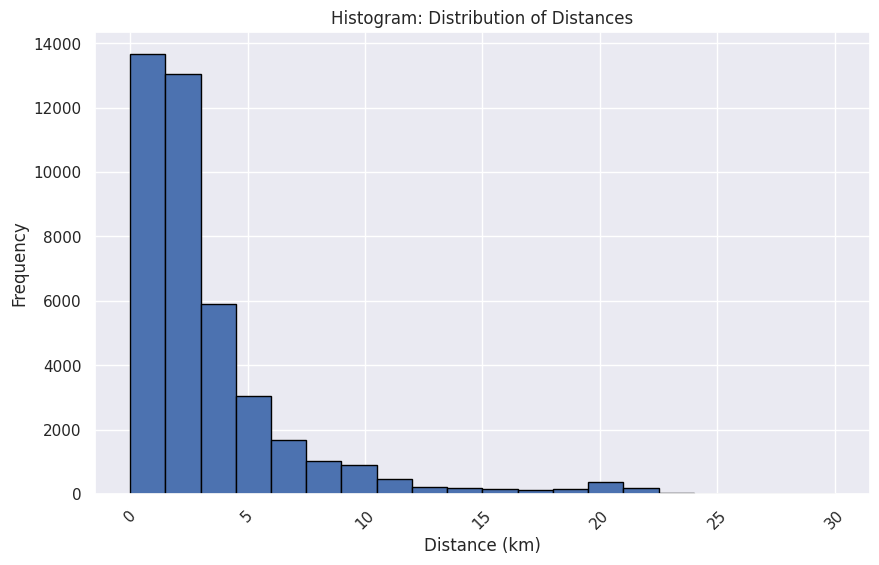

In [15]:
#Create histogram for distance distribution
short_range=(0,30)
plt.figure(figsize=(10, 6))

plt.hist(train_set['distance_km'], bins=20, range=short_range,edgecolor='black')

plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.title('Histogram: Distribution of Distances')
plt.xticks(rotation=45)

plt.show()

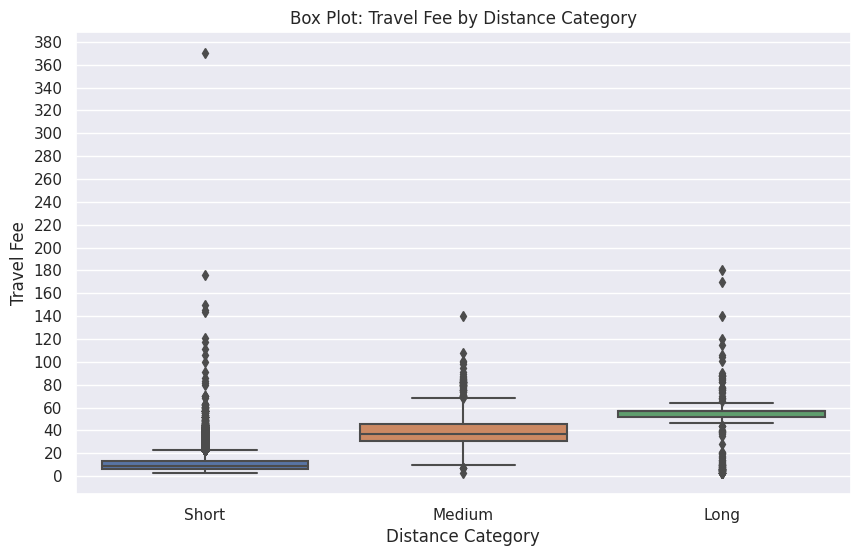

In [271]:
# Create distance categories
bins = [0, 10, 20, float('inf')]
labels = ['Short', 'Medium', 'Long']
train_set['distance_category'] = pd.cut(train_set['distance_km'], bins=bins, labels=labels)
test_set['distance_category'] = pd.cut(train_set['distance_km'], bins=bins, labels=labels)

plt.figure(figsize=(10, 6))
sns.boxplot(x='distance_category', y='travel_fee', data=train_set)
plt.xlabel('Distance Category')
plt.ylabel('Travel Fee')
plt.title('Box Plot: Travel Fee by Distance Category')
plt.yticks(range(0, int(train_set['travel_fee'].max()) + 20, 20))

plt.show()

<ipython-input-17-4f5109fe1d11>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_set.corr()


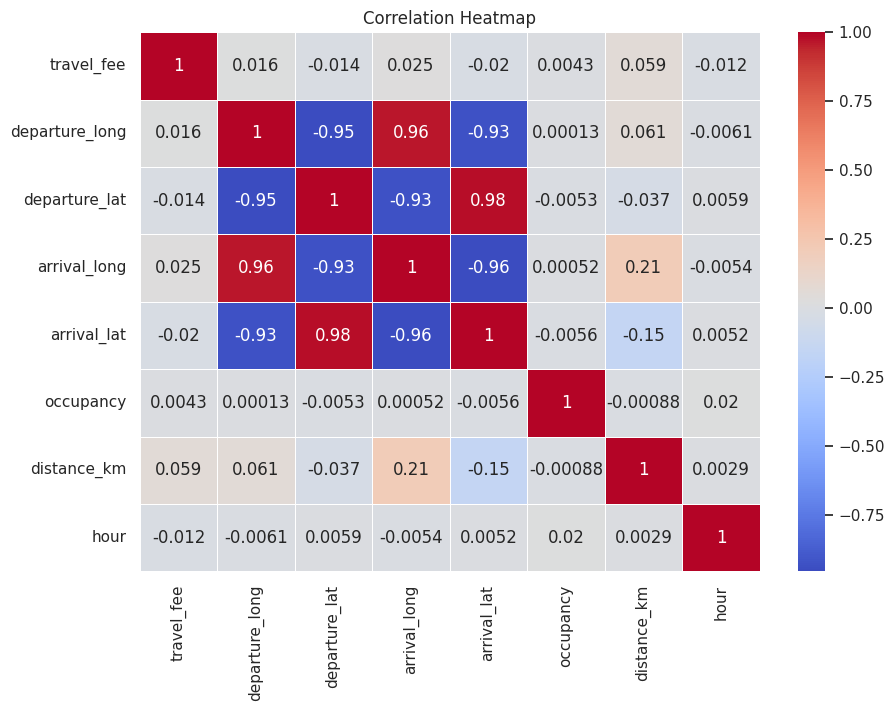

In [17]:
# Calculate the correlation matrix
correlation_matrix = train_set.corr()
# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [18]:
#Calculate minimum and maximum fare
max_fare = train_set['travel_fee'].max()
min_fare = train_set['travel_fee'].min()
print("Maximum Travel Fee:", max_fare)
print("Minimum Travel Fee:", min_fare)

Maximum Travel Fee: 370.0
Minimum Travel Fee: 2.5


In [19]:
#Calculate average fare by occupancy
avg_fare_by_occupancy = train_set.groupby('occupancy')['travel_fee'].mean().reset_index()
print(avg_fare_by_occupancy)

   occupancy  travel_fee
0        1.0   12.481172
1        2.0   13.282336
2        3.0   12.542786
3        4.0   12.723738
4        5.0   12.592210
5        6.0   12.460554


In [272]:
#Calculate the average fare for each distance group
train_set['distance_group'] = pd.cut(train_set['distance_km'], bins=[0, 5, 10, 20, 50, 100, float('inf')], labels=['0-5', '5-10', '10-20', '20-50', '50-100', '>100'])
test_set['distance_group'] = pd.cut(train_set['distance_km'], bins=[0, 5, 10, 20, 50, 100, float('inf')], labels=['0-5', '5-10', '10-20', '20-50', '50-100', '>100'])
avg_fare_by_distance = train_set.groupby('distance_group')['travel_fee'].mean().reset_index()
print(avg_fare_by_distance)

  distance_group  travel_fee
0            0-5    9.072151
1           5-10   21.809577
2          10-20   39.987839
3          20-50   57.573770
4         50-100         NaN
5           >100   24.433333


In [21]:
#Calculate the average fare by hour
#train_set['departure_time'] = pd.to_datetime(train_set['departure_time'])
train_set['hour'] = train_set['departure_time'].dt.hour
avg_fare_by_hour = train_set.groupby('hour')['travel_fee'].mean().reset_index()
print(avg_fare_by_hour)

    hour  travel_fee
0      0   13.013268
1      1   12.300867
2      2   12.460779
3      3   12.521349
4      4   15.469523
5      5   16.353578
6      6   13.221390
7      7   12.227096
8      8   12.220924
9      9   11.892485
10    10   12.554193
11    11   12.218397
12    12   12.115385
13    13   13.171614
14    14   13.125891
15    15   13.273590
16    16   13.452203
17    17   13.136351
18    18   12.354183
19    19   11.592577
20    20   11.845496
21    21   12.109817
22    22   12.486894
23    23   13.148259


In [22]:
#find out the most common occupancy for each ride
most_common_occupancy = train_set['occupancy'].value_counts().idxmax()
print("The occupancy value with the most frequency:", most_common_occupancy)

The occupancy value with the most frequency: 1.0


***Done by Chong Wen Xin***

# Data Preprocessing

In [23]:
train = train_set.drop("travel_fee", axis=1)
train_labels = train_set["travel_fee"].copy()

In [24]:
print(train)

            ID            departure_time  departure_long  departure_lat  \
48271  01:00.0 2013-03-18 20:01:00+00:00      -73.969108      40.760992   
21490  07:00.0 2013-05-03 18:07:00+00:00      -73.999002      40.680602   
12481  43:33.0 2013-04-03 10:43:33+00:00      -73.978440      40.752072   
5020   52:53.0 2013-08-03 19:52:53+00:00      -73.870835      40.773697   
14300  56:24.0 2013-11-02 19:56:24+00:00      -73.978957      40.728178   
...        ...                       ...             ...            ...   
11284  38:00.0 2013-11-02 16:38:00+00:00      -73.976925      40.751702   
44732  05:00.0 2013-07-02 20:05:00+00:00      -73.984522      40.762122   
38158  37:08.0 2013-09-25 16:37:08+00:00      -73.954534      40.773021   
860    50:19.0 2013-08-22 22:50:19+00:00      -73.978476      40.760891   
15795  11:14.0 2013-05-14 19:11:14+00:00      -73.982357      40.767687   

       arrival_long  arrival_lat  occupancy  distance_km  hour time_of_day  \
48271    -73.951433  

In [25]:
train_set.dropna(subset=["distance_category"],inplace=True)

In [26]:
train_set

,ID,travel_fee,departure_time,departure_long,departure_lat,arrival_long,arrival_lat,occupancy,distance_km,hour,time_of_day,distance_category,distance_group
48271,01:00.0,8.50,2013-03-18 20:01:00+00:00,-73.969108,40.760992,-73.951433,40.774237,5.0,2.093969,20,Evening,Short,0-5
21490,07:00.0,17.50,2013-05-03 18:07:00+00:00,-73.999002,40.680602,-73.958238,40.781497,6.0,11.733043,18,Evening,Medium,10-20
12481,43:33.0,11.50,2013-04-03 10:43:33+00:00,-73.978440,40.752072,-73.981830,40.763782,1.0,1.333031,10,Morning,Short,0-5
5020,52:53.0,34.83,2013-08-03 19:52:53+00:00,-73.870835,40.773697,-73.978303,40.766570,1.0,9.084712,19,Evening,Short,5-10
14300,56:24.0,7.00,2013-11-02 19:56:24+00:00,-73.978957,40.728178,-73.994034,40.732560,1.0,1.360658,19,Evening,Short,0-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,38:00.0,8.00,2013-11-02 16:38:00+00:00,-73.976925,40.751702,-73.988952,40.756152,1.0,1.127449,16,Afternoon,Short,0-5
44732,05:00.0,6.50,2013-07-02 20:05:00+00:00,-73.984522,40.762122,-73.977347,40.753625,1.0,1.121565,20,Evening,Short,0-5
38158,37:08.0,4.50,2013-09-25 16:37:08+00:00,-73.954534,40.773021,-73.947192,40.777644,1.0,0.804031,16,Afternoon,Short,0-5
860,50:19.0,7.50,2013-08-22 22:50:19+00:00,-73.978476,40.760891,-73.961469,40.774297,1.0,2.067233,22,Evening,Short,0-5


In [27]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40235 entries, 48271 to 15795
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   ID                 40235 non-null  object             
 1   travel_fee         40235 non-null  float64            
 2   departure_time     40235 non-null  datetime64[ns, UTC]
 3   departure_long     40235 non-null  float64            
 4   departure_lat      40235 non-null  float64            
 5   arrival_long       40235 non-null  float64            
 6   arrival_lat        40235 non-null  float64            
 7   occupancy          40235 non-null  float64            
 8   distance_km        40235 non-null  float64            
 9   hour               40235 non-null  int64              
 10  time_of_day        40235 non-null  category           
 11  distance_category  40235 non-null  category           
 12  distance_group     40235 non-null  categor

In [28]:
# check duplication

In [29]:
train_set.drop_duplicates(inplace=True)
train_set.duplicated().sum()

0

In [30]:
#divide column to category or numerical

cat_attribs = ['time_of_day', 'distance_category', 'distance_group','departure_time','ID']
num_attribs = ['occupancy', 'distance_km', 'hour','departure_long','departure_lat','arrival_long','arrival_lat']

num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])


In [31]:
spreadsheet_prepared = preprocessing.fit_transform(train)
spreadsheet_prepared

<41250x43798 sparse matrix of type '<class 'numpy.float64'>'
	with 495000 stored elements in Compressed Sparse Row format>

In [32]:
preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['occupancy', 'distance_km', 'hour',
                                  'departure_long', 'departure_lat',
                                  'arrival_long', 'arrival_lat']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['time_of_day', 'distance_category',
                                  'distance_group', 'departure_time', 'ID'])])

***Done by Kick Chin Fung***

In [33]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [34]:
import numpy as np
travel_num = train_set.select_dtypes(include=[np.number])
imputer.fit(travel_num)

SimpleImputer(strategy='median')

In [35]:
print(imputer.statistics_)
print(travel_num.median().values)

[  9.5        -73.98201     40.753148   -73.980498    40.753565
   1.           2.21284591  14.        ]
[  9.5        -73.98201     40.753148   -73.980498    40.753565
   1.           2.21284591  14.        ]


In [36]:
X = imputer.transform(travel_num)

In [37]:
travel_tr = pd.DataFrame(X, columns=travel_num.columns, index=travel_num.index)
travel_tr.head()

,travel_fee,departure_long,departure_lat,arrival_long,arrival_lat,occupancy,distance_km,hour
48271,8.50,-73.969108,40.760992,-73.951433,40.774237,5.0,2.093969,20.0
21490,17.50,-73.999002,40.680602,-73.958238,40.781497,6.0,11.733043,18.0
12481,11.50,-73.978440,40.752072,-73.981830,40.763782,1.0,1.333031,10.0
5020,34.83,-73.870835,40.773697,-73.978303,40.766570,1.0,9.084712,19.0
14300,7.00,-73.978957,40.728178,-73.994034,40.732560,1.0,1.360658,19.0


In [38]:
# Feature Encoding

In [39]:
# Feature Encoding for distance_group

In [40]:
train_cat = train_set[["distance_group"]]
train_cat.head(8)

,distance_group
48271,0-5
21490,10-20
12481,0-5
5020,5-10
14300,0-5
33812,5-10
48192,0-5
41412,0-5


In [41]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
train_cat_encoded = ordinal_encoder.fit_transform(train_cat)
train_cat_encoded

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [42]:
ordinal_encoder.categories_

[array(['0-5', '10-20', '20-50', '5-10', '>100'], dtype=object)]

In [43]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
train_cat_1hot = cat_encoder.fit_transform(train_cat)
train_cat_1hot

<40235x5 sparse matrix of type '<class 'numpy.float64'>'
	with 40235 stored elements in Compressed Sparse Row format>

In [44]:
# Feature Encoding for distance_category

In [45]:
train_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [46]:
cat_encoder.categories_

[array(['0-5', '10-20', '20-50', '5-10', '>100'], dtype=object)]

In [47]:
cat_encoder.feature_names_in_

array(['distance_group'], dtype=object)

In [48]:
cat_encoder.get_feature_names_out()

array(['distance_group_0-5', 'distance_group_10-20',
       'distance_group_20-50', 'distance_group_5-10',
       'distance_group_>100'], dtype=object)

In [49]:
train_cat1 = train_set[["distance_category"]]
train_cat1.head(8)

,distance_category
48271,Short
21490,Medium
12481,Short
5020,Short
14300,Short
33812,Short
48192,Short
41412,Short


In [50]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
train_cat1_encoded = ordinal_encoder.fit_transform(train_cat1)
train_cat1_encoded

array([[2.],
       [1.],
       [2.],
       ...,
       [2.],
       [2.],
       [2.]])

In [51]:
ordinal_encoder.categories_

[array(['Long', 'Medium', 'Short'], dtype=object)]

In [52]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
train_cat_2hot = cat_encoder.fit_transform(train_cat1)
train_cat_2hot

<40235x3 sparse matrix of type '<class 'numpy.float64'>'
	with 40235 stored elements in Compressed Sparse Row format>

In [53]:
train_cat_2hot.toarray()

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [54]:
cat_encoder.categories_

[array(['Long', 'Medium', 'Short'], dtype=object)]

In [55]:
cat_encoder.feature_names_in_

array(['distance_category'], dtype=object)

In [56]:
cat_encoder.get_feature_names_out()

array(['distance_category_Long', 'distance_category_Medium',
       'distance_category_Short'], dtype=object)

In [57]:
#Feature Encoding for departure time

In [58]:
train_cat2 = train_set[["departure_time"]]
train_cat2.head(8)

,departure_time
48271,2013-03-18 20:01:00+00:00
21490,2013-05-03 18:07:00+00:00
12481,2013-04-03 10:43:33+00:00
5020,2013-08-03 19:52:53+00:00
14300,2013-11-02 19:56:24+00:00
33812,2013-05-03 22:06:26+00:00
48192,2013-02-19 08:32:30+00:00
41412,2013-08-28 07:08:00+00:00


In [59]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
train_cat2_encoded = ordinal_encoder.fit_transform(train_cat2)
train_cat2_encoded

array([[ 8654.],
       [13843.],
       [10332.],
       ...,
       [28761.],
       [25273.],
       [15141.]])

In [60]:
ordinal_encoder.categories_

[array([Timestamp('2013-01-01 00:18:29+0000', tz='UTC'),
        Timestamp('2013-01-01 00:23:23+0000', tz='UTC'),
        Timestamp('2013-01-01 00:59:00+0000', tz='UTC'), ...,
        Timestamp('2013-12-31 23:21:09+0000', tz='UTC'),
        Timestamp('2013-12-31 23:50:06+0000', tz='UTC'),
        Timestamp('2013-12-31 23:50:54+0000', tz='UTC')], dtype=object)]

In [61]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
train_cat_3hot = cat_encoder.fit_transform(train_cat2)
train_cat_3hot

<40235x39227 sparse matrix of type '<class 'numpy.float64'>'
	with 40235 stored elements in Compressed Sparse Row format>

In [62]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40235 entries, 48271 to 15795
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   ID                 40235 non-null  object             
 1   travel_fee         40235 non-null  float64            
 2   departure_time     40235 non-null  datetime64[ns, UTC]
 3   departure_long     40235 non-null  float64            
 4   departure_lat      40235 non-null  float64            
 5   arrival_long       40235 non-null  float64            
 6   arrival_lat        40235 non-null  float64            
 7   occupancy          40235 non-null  float64            
 8   distance_km        40235 non-null  float64            
 9   hour               40235 non-null  int64              
 10  time_of_day        40235 non-null  category           
 11  distance_category  40235 non-null  category           
 12  distance_group     40235 non-null  categor

In [63]:
# Feature Encoding for time of day

In [64]:
train_cat3 = train_set[["time_of_day"]]
train_cat3.head(8)

,time_of_day
48271,Evening
21490,Evening
12481,Morning
5020,Evening
14300,Evening
33812,Evening
48192,Morning
41412,Morning


In [65]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
train_cat3_encoded = ordinal_encoder.fit_transform(train_cat3)
train_cat3_encoded

array([[1.],
       [1.],
       [2.],
       ...,
       [0.],
       [1.],
       [1.]])

In [66]:
ordinal_encoder.categories_

[array(['Afternoon', 'Evening', 'Morning', 'Night'], dtype=object)]

In [67]:
#Feature Encoding for ID

In [68]:
train_cat4 = train_set[["ID"]]
train_cat4.head(8)

,ID
48271,01:00.0
21490,07:00.0
12481,43:33.0
5020,52:53.0
14300,56:24.0
33812,06:26.0
48192,32:30.0
41412,08:00.0


In [69]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
train_cat4_encoded = ordinal_encoder.fit_transform(train_cat4)
train_cat4_encoded

array([[  59.],
       [ 417.],
       [2602.],
       ...,
       [2220.],
       [3008.],
       [ 671.]])

In [70]:
ordinal_encoder.categories_

[array(['00:00.0', '00:01.0', '00:02.0', ..., '59:57.0', '59:58.0',
        '59:59.0'], dtype=object)]

In [71]:
#Feature Scalling

In [72]:
# scale the numerical variable

In [73]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(travel_num)
housing_num_min_max_scaled

array([[-0.96734694, -0.85636673,  0.85374174, ...,  0.6       ,
        -0.99951752,  0.73913043],
       [-0.91836735, -0.85685022,  0.85244336, ...,  1.        ,
        -0.99729644,  0.56521739],
       [-0.95102041, -0.85651766,  0.85359767, ..., -1.        ,
        -0.99969286, -0.13043478],
       ...,
       [-0.98911565, -0.85613102,  0.85393602, ..., -1.        ,
        -0.99981475,  0.39130435],
       [-0.97278912, -0.85651824,  0.85374011, ..., -1.        ,
        -0.99952368,  0.91304348],
       [-0.96734694, -0.85658101,  0.85384987, ..., -1.        ,
        -0.99971043,  0.65217391]])

In [74]:
training_dataset = train_set.drop("travel_fee", axis=1)

training_dataset.drop_duplicates(inplace=True)
training_dataset.duplicated().sum()

0

In [75]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
travel_num_std_scaled = std_scaler.fit_transform(travel_num)
travel_num_std_scaled

array([[-0.38046255, -0.05975279,  0.06048151, ...,  2.38398352,
        -0.04725497,  0.99556557],
       [ 0.4531491 , -0.06420486,  0.04822645, ...,  3.1091198 ,
        -0.02097497,  0.68902027],
       [-0.102592  , -0.06114259,  0.0591217 , ..., -0.5165616 ,
        -0.04932959, -0.53716092],
       ...,
       [-0.75095662, -0.0575823 ,  0.06231528, ..., -0.5165616 ,
        -0.05077186,  0.38247497],
       [-0.47308607, -0.06114795,  0.06046612, ..., -0.5165616 ,
        -0.04732786,  1.30211087],
       [-0.38046255, -0.06172594,  0.06150214, ..., -0.5165616 ,
        -0.04953758,  0.84229292]])

In [76]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

cat_attribs = ['time_of_day', 'distance_category', 'distance_group','departure_time','ID']
num_attribs = ['occupancy', 'distance_km', 'hour','departure_long','departure_lat','arrival_long','arrival_lat']

num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])


In [77]:
train_prepared = preprocessing.fit_transform(train_set)
train_prepared

<40235x42832 sparse matrix of type '<class 'numpy.float64'>'
	with 482820 stored elements in Compressed Sparse Row format>

In [78]:
preprocessing.get_feature_names_out()

array(['num__occupancy', 'num__distance_km', 'num__hour', ...,
       'cat__ID_59:57.0', 'cat__ID_59:58.0', 'cat__ID_59:59.0'],
      dtype=object)

# Modelling

# Modelling - Linear Regression

In [79]:
np.array(train)

array([['01:00.0', Timestamp('2013-03-18 20:01:00+0000', tz='UTC'),
        -73.969108, ..., 'Evening', 'Short', '0-5'],
       ['07:00.0', Timestamp('2013-05-03 18:07:00+0000', tz='UTC'),
        -73.999002, ..., 'Evening', 'Medium', '10-20'],
       ['43:33.0', Timestamp('2013-04-03 10:43:33+0000', tz='UTC'),
        -73.97844, ..., 'Morning', 'Short', '0-5'],
       ...,
       ['37:08.0', Timestamp('2013-09-25 16:37:08+0000', tz='UTC'),
        -73.954534, ..., 'Afternoon', 'Short', '0-5'],
       ['50:19.0', Timestamp('2013-08-22 22:50:19+0000', tz='UTC'),
        -73.978476, ..., 'Evening', 'Short', '0-5'],
       ['11:14.0', Timestamp('2013-05-14 19:11:14+0000', tz='UTC'),
        -73.982357, ..., 'Evening', 'Short', '0-5']], dtype=object)

In [80]:
np.array(train_labels)

array([ 8.5, 17.5, 11.5, ...,  4.5,  7.5,  8.5])

In [81]:
train = train_set.drop("travel_fee", axis=1)
train_labels = train_set["travel_fee"].copy()

In [82]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

cat_attribs = ['time_of_day', 'distance_category', 'distance_group','departure_time','ID']
num_attribs = ['occupancy', 'distance_km', 'hour','departure_long','departure_lat','arrival_long','arrival_lat']

num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [83]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(train, train_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['occupancy', 'distance_km',
                                                   'hour', 'departure_long',
                                                   'departure_lat',
                                                   'arrival_long',
                                                   'arrival_lat']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['time_of_day',
                                                   'distance_category',
                                                   'distance_group',
                                                   'departure_time', 'ID'])])),
                ('linearregression', LinearRegression())])

In [84]:
# predictive value, y_pred - from model
train_predictions = lin_reg.predict(train_set)
train_predictions[:5]

array([ 8.5003202 , 17.49730684, 11.50031604, 34.82799355,  7.00147315])

In [85]:
# y_true - from dataset
train_labels.iloc[:5].values #check the original value

array([ 8.5 , 17.5 , 11.5 , 34.83,  7.  ])

In [86]:
#Performance measurement

In [87]:
#check the training error
from sklearn.metrics import mean_squared_error

linear_rmse = mean_squared_error(train_labels,
                              train_predictions,
                              squared=False) #squared : If True returns MSE value, if False returns RMSE value.
linear_rmse

0.9113960593203184

# (K-fold) cross-validation for linear regression

In [88]:
# check validation error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
lin_rmses = -cross_val_score(lin_reg,
                              train_set, train_labels,
                              scoring="neg_root_mean_squared_error",
                              cv=3)
pd.Series(lin_rmses).describe()

count      3.000000
mean     163.026303
std      120.549093
min       24.698077
25%      121.716313
50%      218.734548
75%      232.190415
max      245.646282
dtype: float64

In [89]:
# validation error= 6.68

In [245]:
# Fine tune

In [309]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("Linear_Regression",LinearRegression()),
])

full_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['occupancy', 'distance_km',
                                                   'hour', 'departure_long',
                                                   'departure_lat',
                                                   'arrival_long',
                                                   'arrival_lat']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['time_of_day',
                                                   'distance_category',
                                                   'distance_group',
                                                   'departure_time', 'ID'])])),
                ('Linear_Regression', LinearRegression())])

# Fine Tuning for Linear Regression

In [310]:
param_grid = [
    {'Linear_Regression__copy_X': [1, 2, 3, 4, 6, 8]}
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=2,
                           scoring='neg_root_mean_squared_error')

grid_search.fit(train, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarnin

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['occupancy',
                                                                          'distance_km',
                                                                          'hour',
                                                                          'departure_long',
                                                                          'departure_lat',
                                                                          'arrival_long',
                                                                          'arrival_lat']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['time_of_day',
                                                                          'distance_category',
                                                                          'distance_group',
                                                                          'departure_time',
                                                                          'ID'])])),
                                       ('Linear_Regression',
                                        LinearRegression())]),
             param_grid=[{'Linear_Regression__copy_X': [1, 2, 3, 4, 6, 8]}],
             scoring='neg_root_mean_squared_error')

In [311]:
grid_search.best_params_

{'Linear_Regression__copy_X': 1}

In [312]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
#[...] # change column names to fit on this page, and show rmse = -score
cv_res.head() # note: the 1st column is the row ID

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Linear_Regression__copy_X,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.600068,0.003123,0.367804,0.009468,1,{'Linear_Regression__copy_X': 1},-12.619605,-12.86313,-12.741368,0.121762,1
1,0.693827,0.085668,0.168052,0.002019,2,{'Linear_Regression__copy_X': 2},-12.619605,-12.86313,-12.741368,0.121762,1
2,1.005568,0.061022,0.418350,0.117042,3,{'Linear_Regression__copy_X': 3},-12.619605,-12.86313,-12.741368,0.121762,1
3,1.095041,0.106459,0.307721,0.000636,4,{'Linear_Regression__copy_X': 4},-12.619605,-12.86313,-12.741368,0.121762,1
4,0.776834,0.021274,0.168579,0.001491,6,{'Linear_Regression__copy_X': 6},-12.619605,-12.86313,-12.741368,0.121762,1


 Analyzing the Best Models and Their Errors




In [314]:
final_model = grid_search.best_estimator_ # includes preprocessing
feature_importances = final_model["Linear_Regression"].coef_
feature_importances.round(2)

array([ 0.26,  0.04, -0.67, ..., -0.43, -1.71,  0.58])

 Evaluate Your System on the Test Set

In [315]:
X_test = test_set.drop("travel_fee", axis=1)
y_test = test_set["travel_fee"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_rmse

11.017984029205413

# Modelling - Decision Tree Regression

In [91]:
from sklearn.tree import DecisionTreeRegressor
tree_regression = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_regression

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['occupancy', 'distance_km',
                                                   'hour', 'departure_long',
                                                   'departure_lat',
                                                   'arrival_long',
                                                   'arrival_lat']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['time_of_day',
                                                   'distance_category',
                                                   'distance_group',
                                                   'departure_time', 'ID'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
# check the training error
tree_regression.fit(train, train_labels)
train_predictions = tree_regression.predict(train)
tree_rmse = mean_squared_error(train_labels, train_predictions, squared=False)
tree_rmse

3.6991422802240704e-15

In [94]:
# training error = 3.76

# (K-fold) Cross-Validation for Decision Tree Regression

In [95]:
# check validation error
from sklearn.model_selection import cross_val_score
tree_rmses = -cross_val_score(tree_regression,
                              train_set, train_labels,
                              scoring="neg_root_mean_squared_error",
                              cv=2)
tree_rmses

array([4.86604179, 5.52222184])

In [96]:
pd.Series(tree_rmses).describe()

count    2.000000
mean     5.194132
std      0.463989
min      4.866042
25%      5.030087
50%      5.194132
75%      5.358177
max      5.522222
dtype: float64

In [97]:
# validation error = 5.19

# Fine Tuning for DecisionTreeRegressor

In [256]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("decision_tree", DecisionTreeRegressor(random_state=42)),
])

full_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['occupancy', 'distance_km',
                                                   'hour', 'departure_long',
                                                   'departure_lat',
                                                   'arrival_long',
                                                   'arrival_lat']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['time_of_day',
                                                   'distance_category',
                                                   'distance_group',
                                                   'departure_time', 'ID'])])),
                ('decision_tree', DecisionTreeRegressor(random_state=42))])

In [257]:
param_grid = [
    {'decision_tree__max_features': [1, 2, 3, 4, 6, 8]}
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=2,
                           scoring='neg_root_mean_squared_error')

grid_search.fit(train, train_labels)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['occupancy',
                                                                          'distance_km',
                                                                          'hour',
                                                                          'departure_long',
                                                                          'departure_lat',
                                                                          'arrival_long',
                                                                          'arrival_lat']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['time_of_day',
                                                                          'distance_category',
                                                                          'distance_group',
                                                                          'departure_time',
                                                                          'ID'])])),
                                       ('decision_tree',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid=[{'decision_tree__max_features': [1, 2, 3, 4, 6, 8]}],
             scoring='neg_root_mean_squared_error')

In [258]:
grid_search.best_params_

{'decision_tree__max_features': 3}

In [259]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
#[...] # change column names to fit on this page, and show rmse = -score
cv_res.head() # note: the 1st column is the row ID

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decision_tree__max_features,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
2,10.893329,0.049953,0.602234,0.026464,3,{'decision_tree__max_features': 3},-14.060330,-14.188399,-14.124364,0.064035,1
5,9.957463,0.415295,0.325554,0.014201,8,{'decision_tree__max_features': 8},-14.250910,-14.089901,-14.170405,0.080504,2
3,9.721994,0.006528,0.648162,0.271925,4,{'decision_tree__max_features': 4},-14.171985,-14.366149,-14.269067,0.097082,3
4,9.878920,0.632287,0.394089,0.092063,6,{'decision_tree__max_features': 6},-13.977289,-14.854768,-14.416028,0.438739,4
1,10.125688,0.958456,0.530303,0.098057,2,{'decision_tree__max_features': 2},-14.530175,-14.633462,-14.581818,0.051644,5


Analyzing the Best Models and Their Errors

In [273]:
final_model = grid_search.best_estimator_# includes preprocessing
feature_importances = final_model["decision_tree"].feature_importances_
feature_importances.round(2)

array([0.01, 0.04, 0.03, ..., 0.  , 0.  , 0.  ])

Evaluate Your System on the Test Set

In [274]:
X_test = test_set.drop("travel_fee", axis=1)
y_test = test_set["travel_fee"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_rmse

13.617744921849825

# Modelling - KNN

In [197]:
train = train_set.drop("travel_fee", axis=1)
train_labels = train_set["travel_fee"].copy()

In [198]:
from sklearn.neighbors import KNeighborsRegressor
knn = make_pipeline(preprocessing, KNeighborsRegressor(n_neighbors=3))
knn

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['occupancy', 'distance_km',
                                                   'hour', 'departure_long',
                                                   'departure_lat',
                                                   'arrival_long',
                                                   'arrival_lat']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['time_of_day',
                                                   'distance_category',
                                                   'distance_group',
                                                   'departure_time', 'ID'])])),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=3))])

In [194]:
train = train_set.drop("travel_fee", axis=1)
train_labels = train_set["travel_fee"].copy()

In [199]:
#knn = KNeighborsRegressor()
knn.fit(train, train_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['occupancy', 'distance_km',
                                                   'hour', 'departure_long',
                                                   'departure_lat',
                                                   'arrival_long',
                                                   'arrival_lat']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['time_of_day',
                                                   'distance_category',
                                                   'distance_group',
                                                   'departure_time', 'ID'])])),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=3))])

In [141]:
train_set.shape

(40235, 13)

In [146]:
train_labels.shape

(40235,)

In [144]:
train.shape

(80470, 13)

In [147]:
train_labels.head()

48271     8.50
21490    17.50
12481    11.50
5020     34.83
14300     7.00
Name: travel_fee, dtype: float64

In [159]:
train = train_set.drop("travel_fee", axis=1)
train_labels = train_set["travel_fee"].copy()

In [176]:
train = train_set.sample(frac=1,replace= True, random_state=1) #, replace=True, random_state=42)
train_predictions = knn.predict(train)
knn_rmse = mean_squared_error(train_labels, train_predictions, squared=False)
knn_rmse # checking training error

14.531294653635829

# (K-fold) Cross Validation for KNN

In [177]:
from sklearn.model_selection import cross_val_score
knn_rmses = -cross_val_score(knn,
                              train_set, train_labels,
                              scoring="neg_root_mean_squared_error",
                              cv=2)
knn_rmses # validation error

array([5.91486064, 6.38989604])

In [178]:
pd.Series(knn_rmses).describe()

count    2.000000
mean     6.152378
std      0.335901
min      5.914861
25%      6.033619
50%      6.152378
75%      6.271137
max      6.389896
dtype: float64

In [179]:
# validation error = 6.15

# Fine tuning for KNN

In [275]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("knn", KNeighborsRegressor(n_neighbors=3)),
])

full_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['occupancy', 'distance_km',
                                                   'hour', 'departure_long',
                                                   'departure_lat',
                                                   'arrival_long',
                                                   'arrival_lat']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['time_of_day',
                                                   'distance_category',
                                                   'distance_group',
                                                   'departure_time', 'ID'])])),
                ('knn', KNeighborsRegressor(n_neighbors=3))])

In [280]:
param_grid = [
    {"knn__n_neighbors": [1, 2, 3, 4, 6, 8]}
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=2,
                           scoring='neg_root_mean_squared_error')

grid_search.fit(train, train_labels)


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['occupancy',
                                                                          'distance_km',
                                                                          'hour',
                                                                          'departure_long',
                                                                          'departure_lat',
                                                                          'arrival_long',
                                                                          'arrival_lat']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['time_of_day',
                                                                          'distance_category',
                                                                          'distance_group',
                                                                          'departure_time',
                                                                          'ID'])])),
                                       ('knn',
                                        KNeighborsRegressor(n_neighbors=3))]),
             param_grid=[{'knn__n_neighbors': [1, 2, 3, 4, 6, 8]}],
             scoring='neg_root_mean_squared_error')

In [281]:
grid_search.best_params_

{'knn__n_neighbors': 8}

In [282]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
#[...] # change column names to fit on this page, and show rmse = -score
cv_res.head() # note: the 1st column is the row ID

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
5,0.544719,0.233377,60.313723,0.375341,8,{'knn__n_neighbors': 8},-11.295754,-11.547831,-11.421793,0.126038,1
4,0.535009,0.027257,58.982920,1.216693,6,{'knn__n_neighbors': 6},-11.517420,-11.734455,-11.625937,0.108517,2
3,0.399363,0.084514,68.145652,7.741475,4,{'knn__n_neighbors': 4},-11.952924,-12.157965,-12.055444,0.102520,3
2,0.557614,0.017374,58.908871,0.654678,3,{'knn__n_neighbors': 3},-12.311997,-12.484357,-12.398177,0.086180,4
1,0.510878,0.017673,60.680415,0.248002,2,{'knn__n_neighbors': 2},-13.067781,-13.203925,-13.135853,0.068072,5


Analyzing the Best Models and Their Errors

In [303]:
final_model = grid_search.best_estimator_ # includes preprocessing
feature_importances = final_model["knn"].n_samples_fit_
feature_importances#.round(2)

40235

-Evaluate Your System on the Test Set

In [304]:
X_test = test_set.drop("travel_fee", axis=1)
y_test = test_set["travel_fee"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_rmse

10.873530871274165

# Modelling - Lasso regression

In [223]:
test = test_set.drop("travel_fee", axis=1)
test_labels = test_set["travel_fee"].copy()

In [220]:
train = train_set.drop("travel_fee", axis=1)
train_labels = train_set["travel_fee"].copy()

In [221]:
from sklearn.linear_model import Lasso

model_lasso = make_pipeline(preprocessing,Lasso(alpha=0.01))
model_lasso

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['occupancy', 'distance_km',
                                                   'hour', 'departure_long',
                                                   'departure_lat',
                                                   'arrival_long',
                                                   'arrival_lat']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['time_of_day',
                                                   'distance_category',
                                                   'distance_group',
                                                   'departure_time', 'ID'])])),
                ('lasso', Lasso(alpha=0.01))])

In [226]:
test_set.head()

,ID,travel_fee,departure_time,departure_long,departure_lat,arrival_long,arrival_lat,occupancy
13835,44:00.0,8.0,2013-12-01 10:44:00+00:00,-73.960267,40.762040,-73.976800,40.751430,1.0
47683,01:00.0,12.5,2013-06-29 16:01:00+00:00,-73.989795,40.767497,-73.977310,40.742687,5.0
12619,35:00.0,18.0,2013-12-25 01:35:00+00:00,-73.983502,40.734442,-73.983097,40.674397,1.0
30937,43:03.0,48.0,2013-01-07 21:43:03+00:00,-73.788745,40.647298,-73.990070,40.606869,1.0
37119,03:00.0,14.0,2013-04-20 12:03:00+00:00,-74.002570,40.739607,-73.998052,40.716962,1.0


In [227]:
#check training error
train = train_set.sample(frac=1,replace= True, random_state=1)
model_lasso.fit(train, train_labels)

pred_train_lasso= model_lasso.predict(train)
print(np.sqrt(mean_squared_error(train_labels,pred_train_lasso)))
#print(r2_score(y_train, pred_train_lasso))

#pred_test_lasso= model_lasso.predict(test)
#print(np.sqrt(mean_squared_error(test_label,pred_test_lasso)))
#print(r2_score(y_test, pred_test_lasso))

10.795542275063642


# (K-fold) Cross Validation for Lasso

In [229]:
from sklearn.model_selection import cross_val_score
lasso = -cross_val_score(model_lasso,
                              train, train_labels,
                              scoring="neg_root_mean_squared_error",
                              cv=2)
lasso

array([10.63722283, 10.97304185])

In [230]:
pd.Series(lasso).describe()

count     2.000000
mean     10.805132
std       0.237460
min      10.637223
25%      10.721178
50%      10.805132
75%      10.889087
max      10.973042
dtype: float64

In [ ]:
# validation error = 10.81

# Fine tune for Lasso

In [317]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("Lasso", Lasso(alpha=0.01)),
])

full_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['occupancy', 'distance_km',
                                                   'hour', 'departure_long',
                                                   'departure_lat',
                                                   'arrival_long',
                                                   'arrival_lat']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['time_of_day',
                                                   'distance_category',
                                                   'distance_group',
                                                   'departure_time', 'ID'])])),
                ('Lasso', Lasso(alpha=0.01))])

In [318]:
param_grid = [
    {'Lasso__fit_intercept': [1, 2, 3, 4, 6, 8]}
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=2,
                           scoring='neg_root_mean_squared_error')

grid_search.fit(train, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarnin

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['occupancy',
                                                                          'distance_km',
                                                                          'hour',
                                                                          'departure_long',
                                                                          'departure_lat',
                                                                          'arrival_long',
                                                                          'arrival_lat']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['time_of_day',
                                                                          'distance_category',
                                                                          'distance_group',
                                                                          'departure_time',
                                                                          'ID'])])),
                                       ('Lasso', Lasso(alpha=0.01))]),
             param_grid=[{'Lasso__fit_intercept': [1, 2, 3, 4, 6, 8]}],
             scoring='neg_root_mean_squared_error')

In [319]:
grid_search.best_params_

{'Lasso__fit_intercept': 1}

In [320]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
#[...] # change column names to fit on this page, and show rmse = -score
cv_res.head() # note: the 1st column is the row ID

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Lasso__fit_intercept,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,29.637466,10.372285,0.236628,0.067374,1,{'Lasso__fit_intercept': 1},-10.637223,-10.973042,-10.805132,0.16791,1
1,29.353559,9.578809,0.234852,0.070550,2,{'Lasso__fit_intercept': 2},-10.637223,-10.973042,-10.805132,0.16791,1
2,28.757446,9.789030,0.359111,0.192904,3,{'Lasso__fit_intercept': 3},-10.637223,-10.973042,-10.805132,0.16791,1
3,28.934921,10.133570,0.232708,0.068924,4,{'Lasso__fit_intercept': 4},-10.637223,-10.973042,-10.805132,0.16791,1
4,28.382467,9.804332,0.331678,0.166024,6,{'Lasso__fit_intercept': 6},-10.637223,-10.973042,-10.805132,0.16791,1


Analyzing the Best Models and Their Errors

In [322]:
final_model = grid_search.best_estimator_ # includes preprocessing
feature_importances = final_model["Lasso"].intercept_
feature_importances.round(2)

12.42

Evaluate Your System on the Test Set

In [323]:
X_test = test_set.drop("travel_fee", axis=1)
y_test = test_set["travel_fee"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_rmse

10.359216547631823

# modelling - Ridge Regression

In [232]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("lasso", Lasso()),
])

full_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['occupancy', 'distance_km',
                                                   'hour', 'departure_long',
                                                   'departure_lat',
                                                   'arrival_long',
                                                   'arrival_lat']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['time_of_day',
                                                   'distance_category',
                                                   'distance_group',
                                                   'departure_time', 'ID'])])),
                ('lasso', Lasso())])

In [238]:
train = train_set.drop("travel_fee", axis=1)
train_labels = train_set["travel_fee"].copy()

In [240]:
from sklearn.linear_model import Ridge

model_ridge = make_pipeline(preprocessing,Ridge(alpha=0.01))
model_ridge

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['occupancy', 'distance_km',
                                                   'hour', 'departure_long',
                                                   'departure_lat',
                                                   'arrival_long',
                                                   'arrival_lat']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['time_of_day',
                                                   'distance_category',
                                                   'distance_group',
                                                   'departure_time', 'ID'])])),
                ('ridge', Ridge(alpha=0.01))])

In [241]:
#check training error
train = train_set.sample(frac=1,replace= True, random_state=1)
model_ridge.fit(train, train_labels)

pred_train_lasso= model_ridge.predict(train)
print(np.sqrt(mean_squared_error(train_labels,pred_train_lasso)))

6.667610059014945


# (K-fold) Cross Validation for Ridge

In [242]:
from sklearn.model_selection import cross_val_score
ridge = -cross_val_score(model_ridge,
                              train, train_labels,
                              scoring="neg_root_mean_squared_error",
                              cv=2)
ridge

array([12.55969453, 12.8111871 ])

In [243]:
pd.Series(ridge).describe()

count     2.000000
mean     12.685441
std       0.177832
min      12.559695
25%      12.622568
50%      12.685441
75%      12.748314
max      12.811187
dtype: float64

In [ ]:
# validation error = 12.69

# fine tune for ridge

In [325]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("Ridge", Ridge(alpha=0.01)),
])

full_pipeline


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['occupancy', 'distance_km',
                                                   'hour', 'departure_long',
                                                   'departure_lat',
                                                   'arrival_long',
                                                   'arrival_lat']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['time_of_day',
                                                   'distance_category',
                                                   'distance_group',
                                                   'departure_time', 'ID'])])),
                ('Ridge', Ridge(alpha=0.01))])

In [326]:
param_grid = [
    {'Ridge__random_state': [1, 2, 3, 4, 6, 8]}
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=2,
                           scoring='neg_root_mean_squared_error')

grid_search.fit(train, train_labels)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['occupancy',
                                                                          'distance_km',
                                                                          'hour',
                                                                          'departure_long',
                                                                          'departure_lat',
                                                                          'arrival_long',
                                                                          'arrival_lat']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['time_of_day',
                                                                          'distance_category',
                                                                          'distance_group',
                                                                          'departure_time',
                                                                          'ID'])])),
                                       ('Ridge', Ridge(alpha=0.01))]),
             param_grid=[{'Ridge__random_state': [1, 2, 3, 4, 6, 8]}],
             scoring='neg_root_mean_squared_error')

In [327]:
grid_search.best_params_

{'Ridge__random_state': 1}

In [328]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
#[...] # change column names to fit on this page, and show rmse = -score
cv_res.head() # note: the 1st column is the row ID

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Ridge__random_state,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,1.362533,0.176386,0.511937,0.057754,1,{'Ridge__random_state': 1},-12.559695,-12.811187,-12.685441,0.125746,1
1,0.954975,0.014600,0.267810,0.033282,2,{'Ridge__random_state': 2},-12.559695,-12.811187,-12.685441,0.125746,1
2,1.082184,0.091342,0.319281,0.011223,3,{'Ridge__random_state': 3},-12.559695,-12.811187,-12.685441,0.125746,1
3,1.006764,0.125513,0.234078,0.060277,4,{'Ridge__random_state': 4},-12.559695,-12.811187,-12.685441,0.125746,1
4,0.572324,0.027501,0.379212,0.009489,6,{'Ridge__random_state': 6},-12.559695,-12.811187,-12.685441,0.125746,1


Analyzing the Best Models and Their Errors

In [333]:
final_model = grid_search.best_estimator_ # includes preprocessing
feature_importances = final_model["Ridge"].n_features_in_
feature_importances

28476

Evaluate Your System on the Test Set

In [334]:
X_test = test_set.drop("travel_fee", axis=1)
y_test = test_set["travel_fee"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_rmse

10.993121698114416